# Dogbolt ast study

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os
import numpy as np

## Dependencies and dataset

In [8]:
# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

LOGS_PATH = './llm_server/logs/llm_metrics_db.csv'
REPORT_PATH = './dogbolt_bench/outputs/dogbolt_report.json'

# Reports study

In [9]:
# Load Dogbolt report
def load_dogbolt_data(path):
    try:
        with open(path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading file: {e}")
        return pd.DataFrame()

    rows = []
    for model_name, items in data.items():
        for item in items:
            row = {
                'judge_model': model_name,
                'binary': item.get('binary'),
                'function': item.get('function'),
                'decompiler_A': item.get('decompiler_A'),
                'decompiler_B': item.get('decompiler_B'),
                'winner': item.get('winner'),
                'motivation': item.get('motivation', ''),
                
                # Code Perplexity Metrics
                'perp_source': item.get('perplexity_source'),
                'perp_A': item.get('perplexity_A'),
                'perp_B': item.get('perplexity_B'),
                
                # AST Perplexity Metrics
                'perp_ast_source': item.get('perplexity_ast_source'),
                'perp_ast_A': item.get('perplexity_ast_A'),
                'perp_ast_B': item.get('perplexity_ast_B'),
            }
            
            # Skip records with invalid perplexity (-1)
            if (row['perp_source'] == -1 or row['perp_A'] == -1 or row['perp_B'] == -1 or
                row['perp_ast_source'] == -1 or row['perp_ast_A'] == -1 or row['perp_ast_B'] == -1):
                continue


            # Calculate Deltas (Differences)
            # Negative delta means A is better (lower perplexity) than B
            if row['perp_A'] is not None and row['perp_B'] is not None:
                row['delta_perp'] = row['perp_A'] - row['perp_B']
            else:
                row['delta_perp'] = None
                
            if row['perp_ast_A'] is not None and row['perp_ast_B'] is not None:
                row['delta_perp_ast'] = row['perp_ast_A'] - row['perp_ast_B']
            else:
                row['delta_perp_ast'] = None

            rows.append(row)

    df = pd.DataFrame(rows)
    
    # Convert numeric columns
    num_cols = ['perp_source', 'perp_A', 'perp_B', 
                'perp_ast_source', 'perp_ast_A', 'perp_ast_B', 
                'delta_perp', 'delta_perp_ast']
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    return df

# Load data
df_db = load_dogbolt_data(REPORT_PATH)
print(f"Loaded {len(df_db)} records.")
df_db.head()

Loaded 1436 records.


,judge_model,binary,function,decompiler_A,decompiler_B,winner,motivation,perp_source,perp_A,perp_B,perp_ast_source,perp_ast_A,perp_ast_B,delta_perp,delta_perp_ast
0,qwen-coder,task-file_buffer_fill-O0,buffer_fill,binary-ninja,ghidra,B,Candidate B follows a more structured approach...,3.015625,1.851562,1.812500,10.5625,7.09375,4.59375,0.039062,2.50000
1,qwen-coder,task-file_buffer_fill-O0,buffer_fill,binary-ninja,hex-rays,B,"Candidate B has a cleaner, more structured app...",3.015625,1.851562,1.710938,10.5625,7.09375,7.09375,0.140625,0.00000
2,qwen-coder,task-file_buffer_fill-O0,buffer_fill,ghidra,hex-rays,B,"Candidate B uses clear variable names, follows...",3.015625,1.812500,1.710938,10.5625,4.59375,7.09375,0.101562,-2.50000
3,qwen-coder,task-file_buffer_fill-O2,buffer_fill,binary-ninja,ghidra,B,Candidate B follows a more structured approach...,3.015625,2.187500,1.992188,10.5625,5.53125,6.31250,0.195312,-0.78125
4,qwen-coder,task-file_buffer_fill-O2,buffer_fill,binary-ninja,hex-rays,B,Candidate B follows a more structured approach...,3.015625,2.187500,2.015625,10.5625,5.53125,7.50000,0.171875,-1.96875


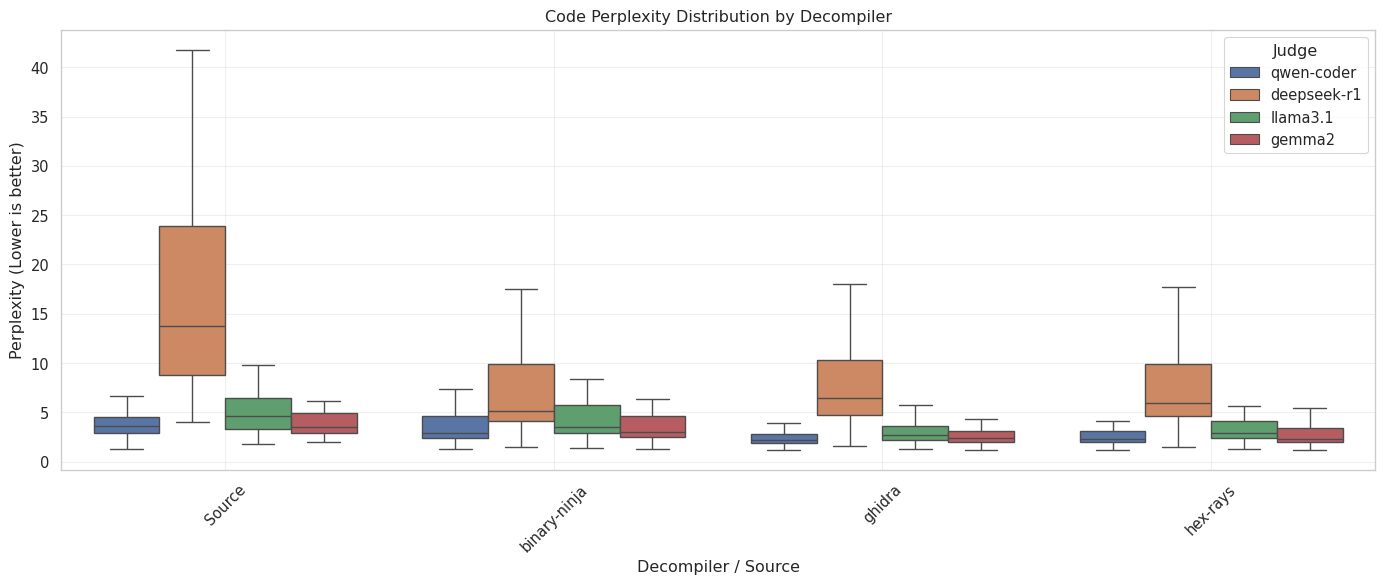

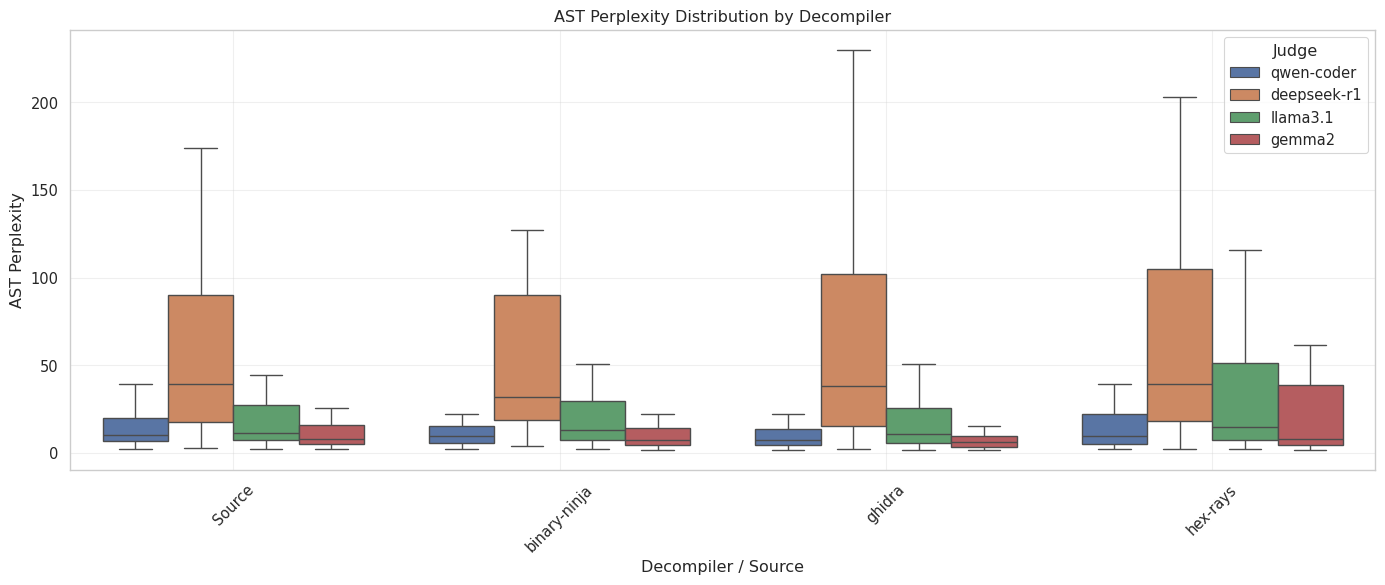

In [10]:
if not df_db.empty:

    plot_data = []
    
    for _, row in df_db.iterrows():
        judge = row['judge_model']
        
        # 1. Source Code Data
        plot_data.append({
            'Judge': judge,
            'Decompiler': 'Source',
            'Perplexity': row['perp_source'],
            'AST Perplexity': row['perp_ast_source'],
            'Type': 'Source'
        })
        
        # 2. Decompiler A Data
        if row['decompiler_A']:
            plot_data.append({
                'Judge': judge,
                'Decompiler': row['decompiler_A'],
                'Perplexity': row['perp_A'],
                'AST Perplexity': row['perp_ast_A'],
                'Type': 'Decompiler'
            })
            
        # 3. Decompiler B Data
        if row['decompiler_B']:
            plot_data.append({
                'Judge': judge,
                'Decompiler': row['decompiler_B'],
                'Perplexity': row['perp_B'],
                'AST Perplexity': row['perp_ast_B'],
                'Type': 'Decompiler'
            })

    df_plot = pd.DataFrame(plot_data)
    
    df_plot = df_plot.dropna(subset=['Perplexity'])
    df_plot = df_plot[df_plot['Perplexity'] != -1]
    
    plt.figure(figsize=(14, 6))
    

    decompilers = sorted(list(set(df_plot['Decompiler']) - {'Source'}))
    order = ['Source'] + decompilers
    
    sns.boxplot(
        data=df_plot, 
        x='Decompiler',
        y='Perplexity', 
        hue='Judge',
        order=order,
        showfliers=False,
    )
    
    plt.title('Code Perplexity Distribution by Decompiler')
    plt.ylabel('Perplexity (Lower is better)')
    plt.xlabel('Decompiler / Source')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    df_plot_ast = df_plot.dropna(subset=['AST Perplexity'])
    df_plot_ast = df_plot_ast[df_plot_ast['AST Perplexity'] != -1]

    if not df_plot_ast.empty:
        plt.figure(figsize=(14, 6))
        
        sns.boxplot(
            data=df_plot_ast, 
            x='Decompiler', 
            y='AST Perplexity', 
            hue='Judge',
            order=order,
            showfliers=False, 
        )
        
        plt.title('AST Perplexity Distribution by Decompiler')
        plt.ylabel('AST Perplexity')
        plt.xlabel('Decompiler / Source')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [11]:

def load_data(path):
    print(f"Loading data from {path}...")
    try:
        with open(path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        return pd.DataFrame()

    # Flatten the dictionary structure
    flattened_data = []
    
    if isinstance(data, dict):
        for judge_model, records in data.items():
            if isinstance(records, list):
                for rec in records:
                    rec['judge_model'] = judge_model
                    flattened_data.append(rec)
            else:
                print(f"Warning: Unexpected structure for key {judge_model}")
    else:
        print("Error: JSON root is not a dictionary as expected.")
        return pd.DataFrame()
        
    df = pd.DataFrame(flattened_data)
    print(f"Loaded {len(df)} records.")
    return df

def clean_winner(row):
    w = str(row.get('winner', 'Unknown')).strip().upper()
    if w in ['A', 'B', 'TIE']:
        return w
    if 'DECOMPILER A' in w: return 'A'
    if 'DECOMPILER B' in w: return 'B'
    return 'Unknown'

df = load_data(REPORT_PATH)
df['clean_winner'] = df.apply(clean_winner, axis=1)

Loading data from ./dogbolt_bench/outputs/dogbolt_report.json...
Loaded 1444 records.


## Distribution victory trough decompilers

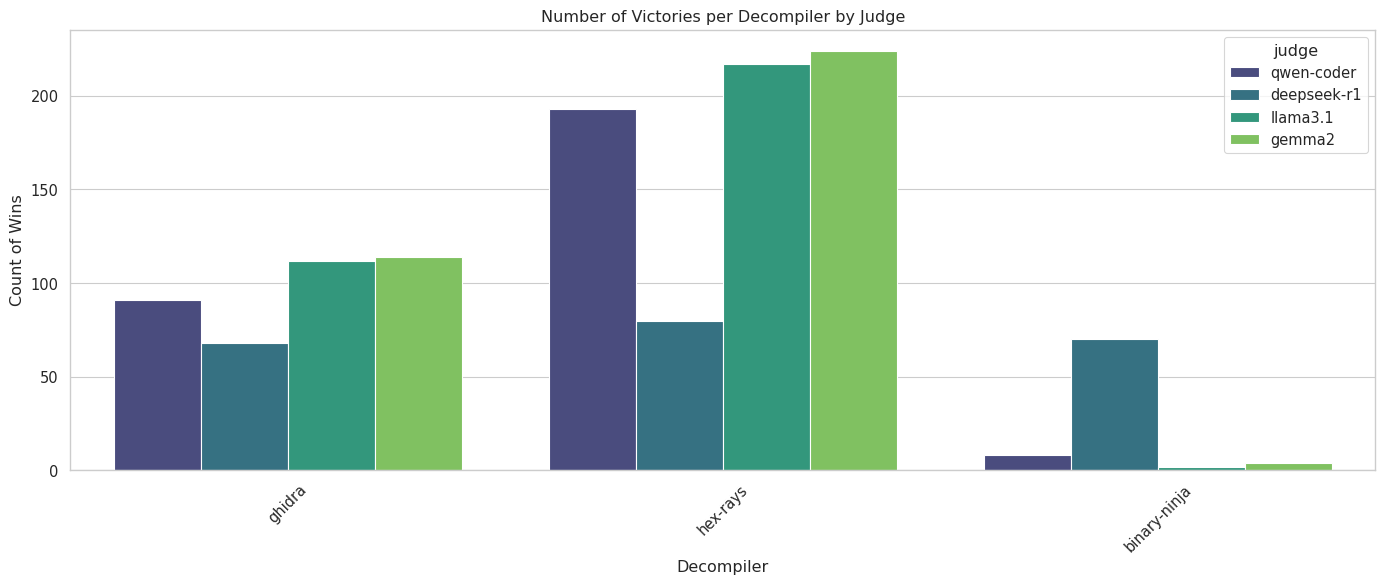

In [12]:
wins = []
for idx, row in df.iterrows():
    w = row['clean_winner']
    if w == 'A':
        wins.append({'decompiler': row['decompiler_A'], 'judge': row['judge_model']})
    elif w == 'B':
        wins.append({'decompiler': row['decompiler_B'], 'judge': row['judge_model']})
        
df_wins = pd.DataFrame(wins)

plt.figure(figsize=(14, 6))
sns.countplot(data=df_wins, x='decompiler', hue='judge', palette='viridis')
plt.title('Number of Victories per Decompiler by Judge')
plt.xlabel('Decompiler')
plt.ylabel('Count of Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Coherence

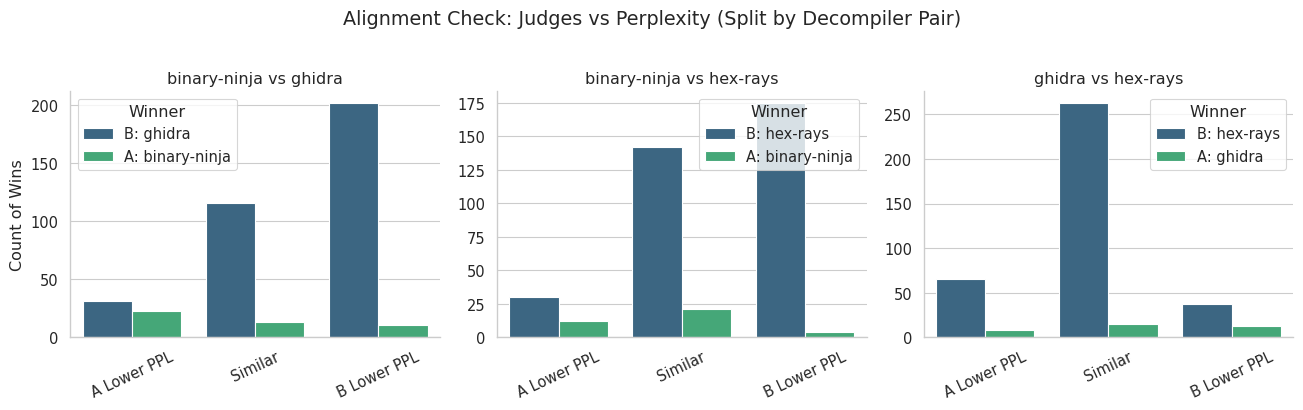

In [13]:
df_valid = df[df['clean_winner'].isin(['A', 'B'])].copy()

LAMBDA = 0.5 
df_valid['delta_ab'] = df_valid['perplexity_A'] - df_valid['perplexity_B']

def categorize_ppl_diff(val):
    if pd.isna(val):
        return 'Unknown'
    if val < -LAMBDA:
        return 'A Lower PPL'   # Metric favors A
    elif val > LAMBDA:
        return 'B Lower PPL'   # Metric favors B
    else:
        return 'Similar'

df_valid['quantitative_reality'] = df_valid['delta_ab'].apply(categorize_ppl_diff)

df_valid = df_valid[df_valid['quantitative_reality'] != 'Unknown']

df_valid['comparison'] = df_valid['decompiler_A'] + ' vs ' + df_valid['decompiler_B']

g = sns.catplot(
    data=df_valid, 
    x='quantitative_reality',
    hue='clean_winner',
    col='comparison',
    col_wrap=3,
    kind='count',
    palette='viridis',
    order=['A Lower PPL', 'Similar', 'B Lower PPL'],
    height=4, 
    aspect=1,
    sharey=False,
    # legend=False
)

g.figure.suptitle('Alignment Check: Judges vs Perplexity (Split by Decompiler Pair)', y=1.02)
g.set_axis_labels("", "Count of Wins")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(25)
    #ax.legend(title='Judge Winner')
    title_text = ax.get_title()
    
    if " = " in title_text:
        pair_name = title_text.split(" = ")[-1] # "Ghidra vs IDA"
    else:
        pair_name = title_text # Fallback
        
    try:
        dec_a, dec_b = pair_name.split(' vs ')
        #print(f"Processing pair: {dec_a} vs {dec_b}")
        
        handles, labels = g._legend_data.values(), g._legend_data.keys()
        #print(f"Original legend labels: {labels}")
        #print(f"Original legend handles: {handles}")
        new_labels = []
        for l in labels:
            if l == 'A':
                new_labels.append(f'A: {dec_a}')
            elif l == 'B':
                new_labels.append(f'B: {dec_b}')
            else:
                new_labels.append(l)

        # print(f"Original labels: {labels}")
        # print(f"New labels: {new_labels}")
        
        ax.legend(handles, new_labels, title='Winner', framealpha=0.8)
        
        ax.set_title(pair_name)
        
        
    except ValueError:
        ax.legend(title='Winner')
g._legend.remove()
plt.tight_layout()
plt.show()

## Length Bias

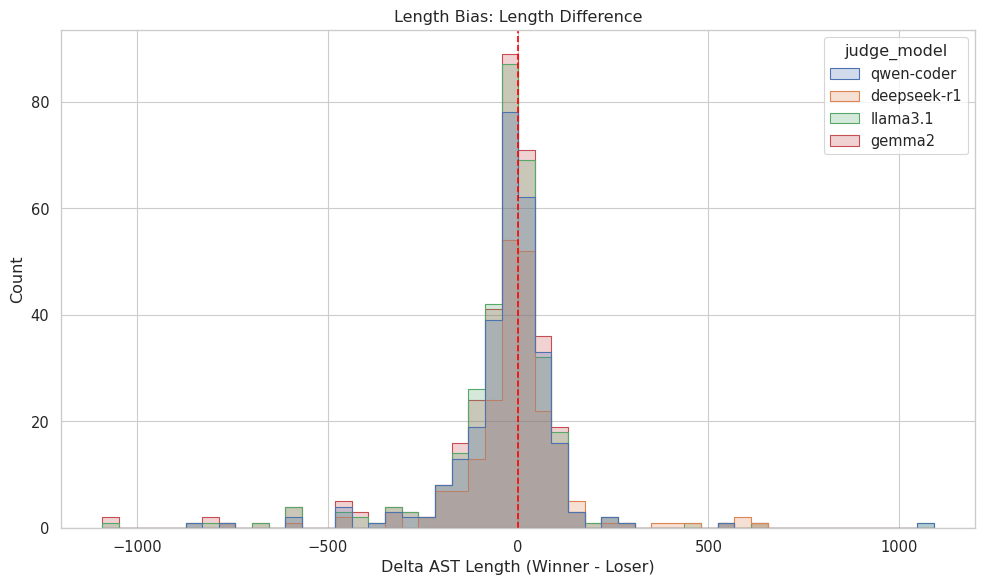

In [14]:
df_valid = df[df['clean_winner'].isin(['A', 'B'])].copy()

df_valid['len_A'] = df_valid['ast_A'].fillna('').astype(str).str.len()
df_valid['len_B'] = df_valid['ast_B'].fillna('').astype(str).str.len()
def get_delta_len(row):
    if row['clean_winner'] == 'A':
        return row['len_A'] - row['len_B']
    else:
        return row['len_B'] - row['len_A']
        
df_valid['delta_len_winner'] = df_valid.apply(get_delta_len, axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_valid, x='delta_len_winner', hue='judge_model', element="step", bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title('Length Bias: Length Difference')
plt.xlabel('Delta AST Length (Winner - Loser)')
plt.tight_layout()
plt.show()

## Position Bias

In [15]:
#check the times the winner is A vs the winner is B
df_valid['clean_winner'].value_counts()

clean_winner
B    1063
A     120
Name: count, dtype: int64

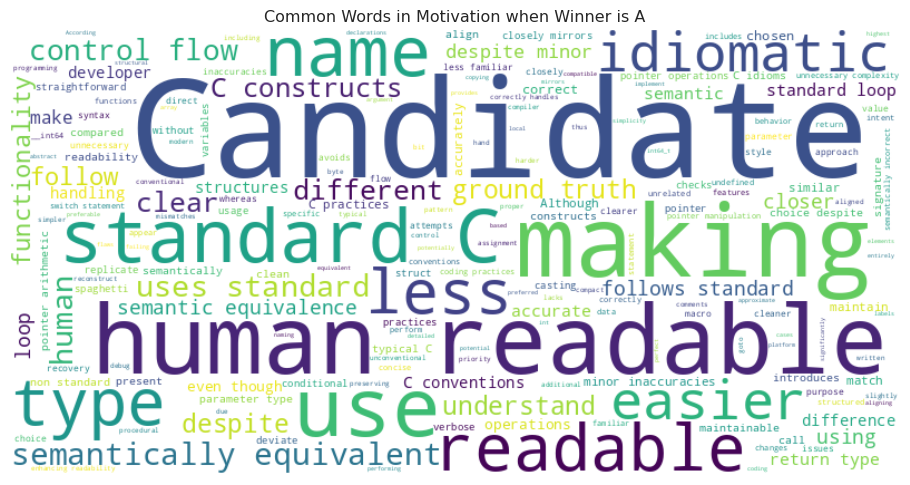

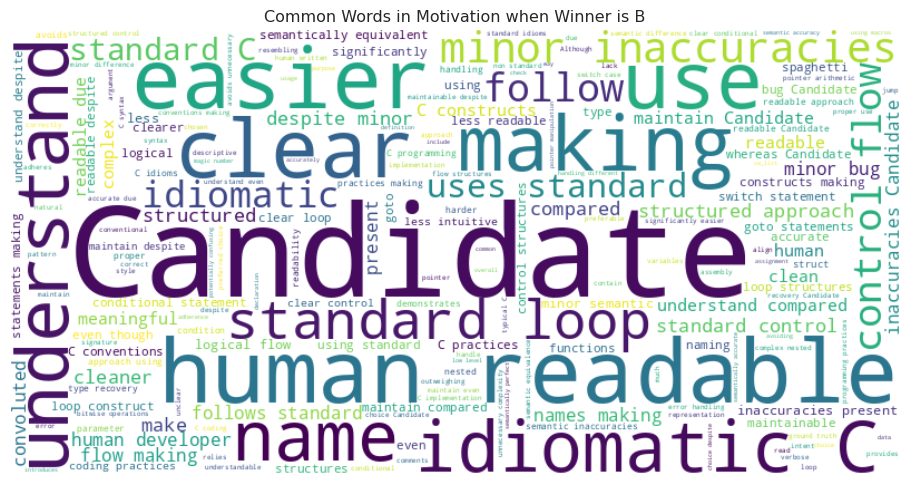

In [16]:
from wordcloud import STOPWORDS, WordCloud

stopwords = set(STOPWORDS)
stopwords.update(['decompiler', 'code', 'source', 'original', 'structure', 'function', 'better', 'variable', 'maintains', 'preserves', 'logic', 'A', 'B', 'winner', 'motivation', 'AST'])

for winner_type in ['A', 'B']:
    text_data = df[df['clean_winner'] == winner_type]['motivation'].dropna().astype(str).str.cat(sep=' ')
    if not text_data: continue
        
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, colormap='viridis').generate(text_data)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Common Words in Motivation when Winner is {winner_type}')
    plt.tight_layout()
    plt.show()

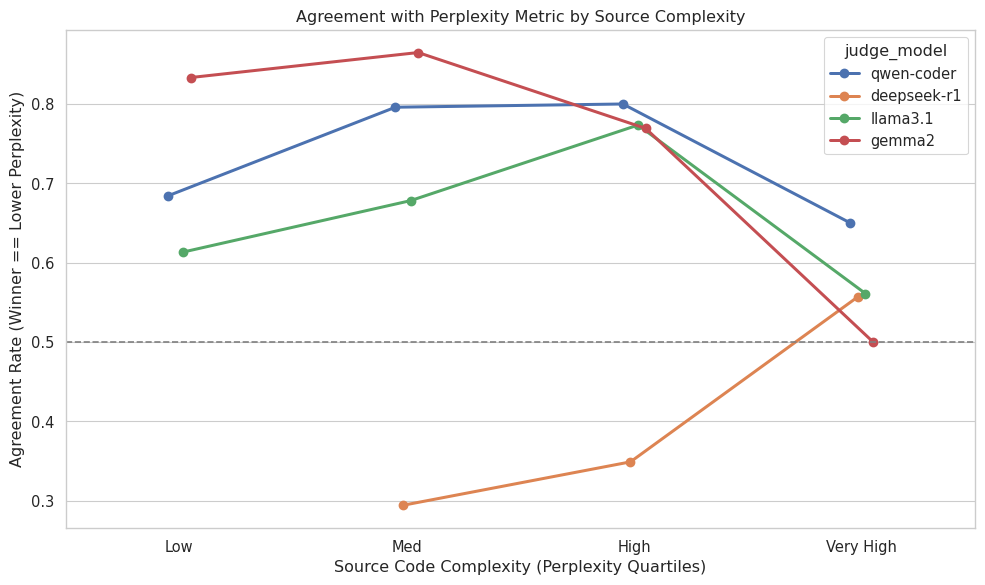

In [17]:
df_valid = df.copy()
df_valid['complexity_bin'] = pd.qcut(df_valid['perplexity_source'], q=4, labels=['Low', 'Med', 'High', 'Very High'])
df_valid['clean_winner'] = df_valid.apply(clean_winner, axis=1)
df_scored = df_valid[df_valid['clean_winner'].isin(['A', 'B'])].copy()

def is_aligned(row):
    if row['clean_winner'] == 'A':
        return row['perplexity_A'] < row['perplexity_B']
    elif row['clean_winner'] == 'B':
        return row['perplexity_B'] < row['perplexity_A']
    return False
    
df_scored['aligned'] = df_scored.apply(is_aligned, axis=1)

plt.figure(figsize=(10, 6))
sns.pointplot(data=df_scored, x='complexity_bin', y='aligned', hue='judge_model', dodge=True, errorbar=None)
plt.axhline(0.5, color='gray', linestyle='--')
plt.title('Agreement with Perplexity Metric by Source Complexity')
plt.xlabel('Source Code Complexity (Perplexity Quartiles)')
plt.ylabel('Agreement Rate (Winner == Lower Perplexity)')
plt.tight_layout()
plt.show()
